## p1. 卷积层conv2d和MaxPool2d

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import collections

In [2]:
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [4]:
data_path = "../../myData/p1ch7/cifar/"
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

In [5]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

查看常规全连接层的参数规模

In [6]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

numel_list = [
    p.numel() for p in connected_model.parameters() if p.requires_grad == True
]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [7]:
first_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1),
)
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

卷积层! 启动!!!

In [8]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [9]:
for name, param in conv.named_parameters():
    print(name, param.shape)

weight torch.Size([16, 3, 3, 3])
bias torch.Size([16])


In [10]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

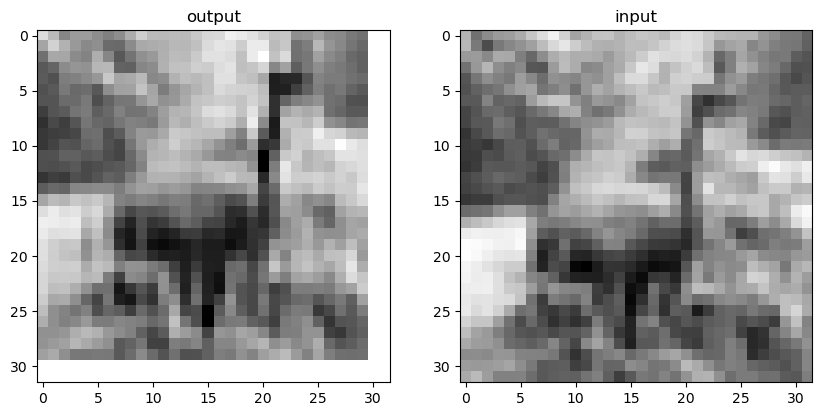

In [11]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title("output")
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.title("input")
plt.imshow(img.mean(0), cmap="gray")
plt.show()

可以看到output必input少一圈

In [12]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [13]:
with torch.no_grad():
    conv.bias.zero_()

# 这里填充1/9是是因为卷积核是3x3的，所以总共有9个元素，我们希望这9个元素的和为1
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

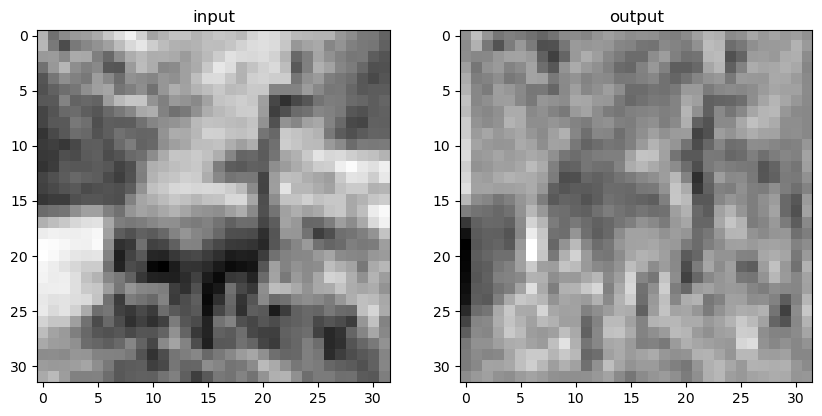

In [14]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img.mean(0), cmap="gray")
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.title("output")
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

上面这个就有点类似模糊滤镜

In [15]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor(
        [[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]]
    )
    conv.bias.zero_()

突然想到，上面这个参数是三个相同的一维张量堆叠起来了，那么在初始化时是否可以像print('\*'\*10)这样的直接写重复了多少次呢，下面试一下。


In [16]:
print("*" * 10)

**********


In [17]:
a = torch.tensor([[-1.0, 0.0, 1.0] * 3])
a, a.shape

(tensor([[-1.,  0.,  1., -1.,  0.,  1., -1.,  0.,  1.]]), torch.Size([1, 9]))

In [18]:
a = torch.tensor([[-1.0, 0.0, 1.0]] * 3)
a, a.shape

(tensor([[-1.,  0.,  1.],
         [-1.,  0.,  1.],
         [-1.,  0.,  1.]]),
 torch.Size([3, 3]))

答案是可以的，因为括号里的参数本质上是个list，python的list就是可以通过使用`*`来重复列表中的内容。
但是需要注意的是，`*`作用在list上是**将list中的元素**多次重复，而不是将list本身重复多次，因此对于上面这种情况，我们需要先构建(1, 3)的list，然后在最外层使用`*`运算符。

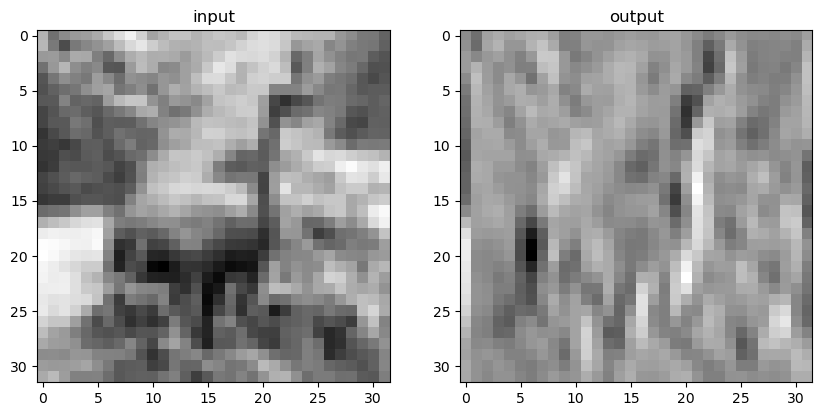

In [19]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title("input")
plt.imshow(img.mean(0), cmap="gray")
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.title("output")
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

可以看到上面运行的结果，卷积核左负右正，因此在卷积时，如果碰到同类型的色块，则卷积结果大，在output中就亮；反之就暗。
因此可以看到output中很明显的几个暗块，就是input中脖子部位的左亮右暗的部位。

池化层! 启动!!!

In [20]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

卷积神经网络! 启动!!!

In [21]:
conv_model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),  # 32x32 -> 16x16
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),  # 16x16 -> 8x8
    # ...
    # 一是在这里添加更多的卷积层
    # 二是需要在这里添加一个展平层，将8x8x8的输出展平为一个长度为512的向量，不然无法连接到全连接层
    # 下面运行报错即可看到
    nn.Linear(8 * 8 * 8, 32),  # 注意这个地方的输入维度计算方式
    nn.Tanh(),
    nn.Linear(32, 2),
)

In [22]:
numel_list = [p.numel() for p in conv_model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [23]:
# 下面这行代码会报错，因为缺少展平层
# 在很老版本的pytorch中并没有展平层，在1.3版本后，nn.Flatten()被加入
# 不过还是建议使用下面介绍的nn.Module的方式来定义模型，这样更加灵活
# conv_model(img.unsqueeze(0))

In [24]:
conv_model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Linear(in_features=512, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=2, bias=True)
)

## p2. 用Module subclass和Functional A

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.act2(out)
        out = self.pool2(out)

        out = out.view(
            -1, 8 * 8 * 8
        )  # 注意，这里将8x8x8的输出展平为一个长度为512的向量

        out = self.fc1(out)
        out = self.act3(out)
        out = self.fc2(out)
        return out

In [26]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): Tanh()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [27]:
# 在forward里进行了展平操作，所以可以运行
model(img.unsqueeze(0))

tensor([[-0.1638,  0.1690]], grad_fn=<AddmmBackward0>)

对比继承nn.Module来构造网络的方法和直接使用nn.Sequential()来说，很明显前者更加灵活

下面使用torch的函数式API来代替子模块中不需要保存参数的部分，如下采样和激活函数等。

In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)

        out = out.view(
            -1, 8 * 8 * 8
        )  # 注意，这里将8x8x8的输出展平为一个长度为512的向量

        out = self.fc1(out)
        out = torch.tanh(out)
        out = self.fc2(out)
        return out

In [29]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [30]:
model(img.unsqueeze(0))

tensor([[-0.0595,  0.1623]], grad_fn=<AddmmBackward0>)

# p.3 用GPU训练卷积网络

In [31]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [32]:
import datetime

In [33]:
def training_loop_cpu(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            output = model(imgs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_val = 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                output = model(imgs)
                loss = loss_fn(output, labels)
                loss_val += loss.item()

        if epoch <= 3 or epoch % 50 == 0:
            print(
                f"{datetime.datetime.now():%H:%M:%S} Epoch: {epoch}, Training loss: {loss_train / len(train_loader)}, Validation loss: {loss_val / len(val_loader)}"
            )

先在cpu上跑一下看看

In [34]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

model = Net()
lr = 1e-2
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 10

In [35]:
training_loop_cpu(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

22:32:08 Epoch: 1, Training loss: 0.5969931709158952, Validation loss: 0.49974647630006075
22:32:10 Epoch: 2, Training loss: 0.49362076752504724, Validation loss: 0.46128271892666817
22:32:11 Epoch: 3, Training loss: 0.4628261403673014, Validation loss: 0.4367945855483413


下面把训练迁移到gpu

In [36]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [57]:
def training_loop_gpu(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    start = datetime.datetime.now()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # 将数据移到GPU上
            # imgs.to(device=device)
            # labels.to(device=device)
            # 上面没注意，后面运行就出了问题，因为to()操作并不是inplace操作，需要重新赋值给imgs和labels...
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            output = model(imgs)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_val = 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                # 将数据移到GPU上
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                output = model(imgs)
                loss = loss_fn(output, labels)
                loss_val += loss.item()

        if epoch <= 3 or epoch % 10 == 0:
            print(
                f"{datetime.datetime.now():%H:%M:%S} Epoch: {epoch}, Training loss: {loss_train / len(train_loader):.4f}, Validation loss: {loss_val / len(val_loader):.4f}"
            )

In [38]:
gpu_model = Net().to(device=device)
lr = 1e-2
optimizer = optim.SGD(gpu_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 100

In [39]:
for name, param in gpu_model.named_parameters():
    print(name, param.shape, param.device)

conv1.weight torch.Size([16, 3, 3, 3]) cuda:0
conv1.bias torch.Size([16]) cuda:0
conv2.weight torch.Size([8, 16, 3, 3]) cuda:0
conv2.bias torch.Size([8]) cuda:0
fc1.weight torch.Size([32, 512]) cuda:0
fc1.bias torch.Size([32]) cuda:0
fc2.weight torch.Size([2, 32]) cuda:0
fc2.bias torch.Size([2]) cuda:0


In [49]:
training_loop_gpu(n_epochs, optimizer, gpu_model, loss_fn, train_loader, val_loader)

22:42:12 Epoch: 1, Training loss: 0.14798682216246417, Validation loss: 0.2728778456803411
22:42:12 Epoch: 2, Training loss: 0.1477435332764486, Validation loss: 0.2728778456803411
22:42:13 Epoch: 3, Training loss: 0.14774681544702523, Validation loss: 0.2728778456803411
22:42:17 Epoch: 10, Training loss: 0.1475313139521772, Validation loss: 0.2728778456803411
22:42:22 Epoch: 20, Training loss: 0.14834344088082102, Validation loss: 0.2728778456803411
22:42:27 Epoch: 30, Training loss: 0.14940330267521987, Validation loss: 0.2728778456803411
22:42:32 Epoch: 40, Training loss: 0.1481921273479416, Validation loss: 0.2728778456803411
22:42:37 Epoch: 50, Training loss: 0.14878070992743894, Validation loss: 0.2728778456803411
22:42:42 Epoch: 60, Training loss: 0.14739075087153228, Validation loss: 0.2728778456803411
22:42:47 Epoch: 70, Training loss: 0.14765008697938767, Validation loss: 0.2728778456803411
22:42:52 Epoch: 80, Training loss: 0.14745107777179425, Validation loss: 0.27287784568

## p4. 模型设计——宽度，参数规范，Drop out, Batch nomalization

### 增加模型"宽度"

In [50]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)

        out = out.view(
            -1, 16 * 8 * 8
        )  # 注意，这里将8x8x8的输出展平为一个长度为512的向量

        out = self.fc1(out)
        out = torch.tanh(out)
        out = self.fc2(out)
        return out

In [51]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=lr)
training_loop_gpu(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

22:43:02 Epoch: 1, Training loss: 0.5552755516425819, Validation loss: 0.4738707607612014
22:43:03 Epoch: 2, Training loss: 0.4663383491859315, Validation loss: 0.44055768474936485
22:43:03 Epoch: 3, Training loss: 0.42350761525949854, Validation loss: 0.3970285402610898
22:43:07 Epoch: 10, Training loss: 0.3113744929907428, Validation loss: 0.328284892719239
22:43:13 Epoch: 20, Training loss: 0.26963735988755133, Validation loss: 0.2936229184269905
22:43:18 Epoch: 30, Training loss: 0.2384980750881183, Validation loss: 0.3033856707625091
22:43:23 Epoch: 40, Training loss: 0.21115876976281975, Validation loss: 0.2659792904742062
22:43:28 Epoch: 50, Training loss: 0.1896387282165752, Validation loss: 0.29537765914574265
22:43:34 Epoch: 60, Training loss: 0.16663591091515154, Validation loss: 0.26929374085739255
22:43:39 Epoch: 70, Training loss: 0.1459533774359211, Validation loss: 0.28212040825746953
22:43:44 Epoch: 80, Training loss: 0.12545126264879278, Validation loss: 0.27699413662

### 使用l2正则

In [52]:
def training_loop_gpu_l2reg(
    n_epochs, optimizer, model, loss_fn, train_loader, val_loader
):
    start = datetime.datetime.now()
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            output = model(imgs)
            loss = loss_fn(output, labels)

            # 加入l2正则化
            l2_lambda = 1e-2
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss += l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_val = 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                # 将数据移到GPU上
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                output = model(imgs)
                loss = loss_fn(output, labels)
                loss_val += loss.item()

        if epoch <= 3 or epoch % 10 == 0:
            print(
                f"{datetime.datetime.now():%H:%M:%S} Epoch: {epoch}, Training loss: {loss_train / len(train_loader):.4f}, Validation loss: {loss_val / len(val_loader):.4f}"
            )

In [58]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=lr)
training_loop_gpu_l2reg(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

22:46:14 Epoch: 1, Training loss: 0.8250, Validation loss: 0.4773
22:46:15 Epoch: 2, Training loss: 0.7249, Validation loss: 0.4422
22:46:16 Epoch: 3, Training loss: 0.6804, Validation loss: 0.4133
22:46:21 Epoch: 10, Training loss: 0.5166, Validation loss: 0.3369
22:46:28 Epoch: 20, Training loss: 0.4362, Validation loss: 0.3147
22:46:36 Epoch: 30, Training loss: 0.3980, Validation loss: 0.3114
22:46:43 Epoch: 40, Training loss: 0.3739, Validation loss: 0.3028
22:46:51 Epoch: 50, Training loss: 0.3590, Validation loss: 0.2951
22:46:59 Epoch: 60, Training loss: 0.3521, Validation loss: 0.3372
22:47:06 Epoch: 70, Training loss: 0.3479, Validation loss: 0.2890
22:47:14 Epoch: 80, Training loss: 0.3402, Validation loss: 0.2810
22:47:23 Epoch: 90, Training loss: 0.3385, Validation loss: 0.2789
22:47:31 Epoch: 100, Training loss: 0.3341, Validation loss: 0.2725


In [59]:
model = Net().to(device=device)
optimizer = optim.Adam(model.parameters())
training_loop_gpu_l2reg(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

22:51:02 Epoch: 1, Training loss: 0.5881, Validation loss: 0.3663
22:51:03 Epoch: 2, Training loss: 0.4591, Validation loss: 0.3471
22:51:04 Epoch: 3, Training loss: 0.4292, Validation loss: 0.3357
22:51:10 Epoch: 10, Training loss: 0.3838, Validation loss: 0.3209
22:51:19 Epoch: 20, Training loss: 0.3606, Validation loss: 0.2896
22:51:27 Epoch: 30, Training loss: 0.3586, Validation loss: 0.3020
22:51:35 Epoch: 40, Training loss: 0.3572, Validation loss: 0.2852
22:51:44 Epoch: 50, Training loss: 0.3539, Validation loss: 0.2946
22:51:52 Epoch: 60, Training loss: 0.3478, Validation loss: 0.2802
22:52:00 Epoch: 70, Training loss: 0.3490, Validation loss: 0.2689
22:52:08 Epoch: 80, Training loss: 0.3506, Validation loss: 0.3021
22:52:17 Epoch: 90, Training loss: 0.3508, Validation loss: 0.2815
22:52:26 Epoch: 100, Training loss: 0.3474, Validation loss: 0.2688


### 使用Drop out层

In [60]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, self.n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(
            self.n_chans1, self.n_chans1 // 2, kernel_size=3, padding=1
        )
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(self.n_chans1 // 2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, self.n_chans1 // 2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [61]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=lr)
training_loop_gpu_l2reg(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

22:52:27 Epoch: 1, Training loss: 0.8602, Validation loss: 0.5086
22:52:28 Epoch: 2, Training loss: 0.7604, Validation loss: 0.4746
22:52:29 Epoch: 3, Training loss: 0.7157, Validation loss: 0.4435
22:52:35 Epoch: 10, Training loss: 0.5714, Validation loss: 0.3960
22:52:43 Epoch: 20, Training loss: 0.4867, Validation loss: 0.3710
22:52:51 Epoch: 30, Training loss: 0.4467, Validation loss: 0.3659
22:52:59 Epoch: 40, Training loss: 0.4227, Validation loss: 0.3555
22:53:07 Epoch: 50, Training loss: 0.4108, Validation loss: 0.3579
22:53:15 Epoch: 60, Training loss: 0.4061, Validation loss: 0.3477
22:53:23 Epoch: 70, Training loss: 0.3983, Validation loss: 0.3487
22:53:31 Epoch: 80, Training loss: 0.3953, Validation loss: 0.3506
22:53:39 Epoch: 90, Training loss: 0.3969, Validation loss: 0.3417
22:53:46 Epoch: 100, Training loss: 0.3956, Validation loss: 0.3503


In [62]:
def validate(model, train_loader, val_loader):
    acc_dict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print(f"Accuracy {name}: {correct / total:.2f}")
        acc_dict[name] = correct / total
    return acc_dict

In [63]:
all_acc_dict = collections.OrderedDict()
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)
all_acc_dict

Accuracy train: 0.85
Accuracy val: 0.85


OrderedDict([('dropout', {'train': 0.8527, 'val': 0.85})])

### 使用batch nomalization

In [64]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, self.n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=self.n_chans1)
        self.conv2 = nn.Conv2d(
            self.n_chans1, self.n_chans1 // 2, kernel_size=3, padding=1
        )
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=self.n_chans1 // 2)
        self.fc1 = nn.Linear(self.n_chans1 // 2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # 需要注意的就是，dropout是在卷积层之后，而batchnorm是在卷积层之前
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, self.n_chans1 // 2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [65]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=lr)
training_loop_gpu_l2reg(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

22:53:48 Epoch: 1, Training loss: 1.2051, Validation loss: 0.4314
22:53:49 Epoch: 2, Training loss: 1.0693, Validation loss: 0.3651
22:53:50 Epoch: 3, Training loss: 1.0008, Validation loss: 0.4156
22:53:57 Epoch: 10, Training loss: 0.7242, Validation loss: 0.4440
22:54:06 Epoch: 20, Training loss: 0.5217, Validation loss: 0.2649
22:54:15 Epoch: 30, Training loss: 0.4179, Validation loss: 0.2860
22:54:24 Epoch: 40, Training loss: 0.3675, Validation loss: 0.3477
22:54:33 Epoch: 50, Training loss: 0.3382, Validation loss: 0.2790
22:54:42 Epoch: 60, Training loss: 0.3226, Validation loss: 0.3176
22:54:51 Epoch: 70, Training loss: 0.3156, Validation loss: 0.2979
22:54:59 Epoch: 80, Training loss: 0.3110, Validation loss: 0.2679
22:55:08 Epoch: 90, Training loss: 0.3071, Validation loss: 0.3494
22:55:17 Epoch: 100, Training loss: 0.3015, Validation loss: 0.2761


In [66]:
all_acc_dict["batchnorm"] = validate(model, train_loader, val_loader)
all_acc_dict

Accuracy train: 0.93
Accuracy val: 0.88


OrderedDict([('dropout', {'train': 0.8527, 'val': 0.85}),
             ('batchnorm', {'train': 0.9321, 'val': 0.8805})])

### 使用残差网络，增加网络深度

In [67]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, self.n_chans1, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(
            self.n_chans1, self.n_chans1 // 2, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            self.n_chans1 // 2, self.n_chans1 // 2, kernel_size=3, padding=1
        )
        self.fc1 = nn.Linear(self.n_chans1 // 2 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # 注意，此处激活函数换成了relu
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, self.n_chans1 // 2 * 4 * 4)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [68]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=lr)
training_loop_gpu(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

22:55:18 Epoch: 1, Training loss: 0.6661, Validation loss: 0.6103
22:55:19 Epoch: 2, Training loss: 0.5492, Validation loss: 0.4902
22:55:19 Epoch: 3, Training loss: 0.4769, Validation loss: 0.4283
22:55:24 Epoch: 10, Training loss: 0.3258, Validation loss: 0.3140
22:55:30 Epoch: 20, Training loss: 0.2848, Validation loss: 0.3564
22:55:35 Epoch: 30, Training loss: 0.2470, Validation loss: 0.3243
22:55:41 Epoch: 40, Training loss: 0.2197, Validation loss: 0.2649
22:55:47 Epoch: 50, Training loss: 0.1963, Validation loss: 0.2761
22:55:53 Epoch: 60, Training loss: 0.1692, Validation loss: 0.4219
22:55:59 Epoch: 70, Training loss: 0.1489, Validation loss: 0.2921
22:56:05 Epoch: 80, Training loss: 0.1210, Validation loss: 0.2805
22:56:11 Epoch: 90, Training loss: 0.1139, Validation loss: 0.2939
22:56:16 Epoch: 100, Training loss: 0.0823, Validation loss: 0.3388


In [69]:
all_acc_dict["res"] = validate(model, train_loader, val_loader)
all_acc_dict

Accuracy train: 0.96
Accuracy val: 0.89


OrderedDict([('dropout', {'train': 0.8527, 'val': 0.85}),
             ('batchnorm', {'train': 0.9321, 'val': 0.8805}),
             ('res', {'train': 0.9641, 'val': 0.8925})])

In [71]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        # 这里为什么先卷积，再batch_norm呢?
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [72]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        # 解释一下下面这行代码
        # Sequential中的第一个*是解包操作，将后面的列表解包成一个个元素
        # 列表中使用了*运算符，这个运算符会将列表中的元素重复n次，然后再合并成一个新的列表
        # 也就是，下面这行代码的意思是，将ResBlock(n_chans=n_chans1)重复n_blocks次，然后将这n_blocks个ResBlock组合成一个Sequential
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(n_chans1 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, self.n_chans1 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [76]:
lr = 3e-3
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=lr)
training_loop_gpu(n_epochs, optimizer, model, loss_fn, train_loader, val_loader)

23:13:46 Epoch: 1, Training loss: 1.6412, Validation loss: 0.5467
23:13:56 Epoch: 2, Training loss: 0.4658, Validation loss: 0.4349
23:14:05 Epoch: 3, Training loss: 0.4170, Validation loss: 0.3997
23:15:10 Epoch: 10, Training loss: 0.3194, Validation loss: 0.3717
23:16:41 Epoch: 20, Training loss: 0.2382, Validation loss: 0.5105
23:18:13 Epoch: 30, Training loss: 0.1822, Validation loss: 0.4222
23:19:44 Epoch: 40, Training loss: 0.1254, Validation loss: 0.6250
23:21:25 Epoch: 50, Training loss: 0.1022, Validation loss: 0.5364
23:23:07 Epoch: 60, Training loss: 0.1116, Validation loss: 0.4902
23:24:36 Epoch: 70, Training loss: 0.0776, Validation loss: 0.5175
23:26:04 Epoch: 80, Training loss: 0.0760, Validation loss: 0.5785
23:27:31 Epoch: 90, Training loss: 0.0708, Validation loss: 0.7018
23:29:02 Epoch: 100, Training loss: 0.0696, Validation loss: 3.5064


In [78]:
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)
all_acc_dict

Accuracy train: 0.63
Accuracy val: 0.63


OrderedDict([('dropout', {'train': 0.8527, 'val': 0.85}),
             ('batchnorm', {'train': 0.9321, 'val': 0.8805}),
             ('res', {'train': 0.9641, 'val': 0.8925}),
             ('res deep', {'train': 0.6316, 'val': 0.63})])